# DPCM Card Game Simulator

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

sns.set()

### Analysis

In [2]:
df = pd.read_csv('../data/results.csv')
df.head()

,Winner,Turns,Rate
0,AI,10,1.000000
1,AI,13,1.000000
2,Human,10,0.666667
3,AI,9,0.750000
4,AI,22,0.800000


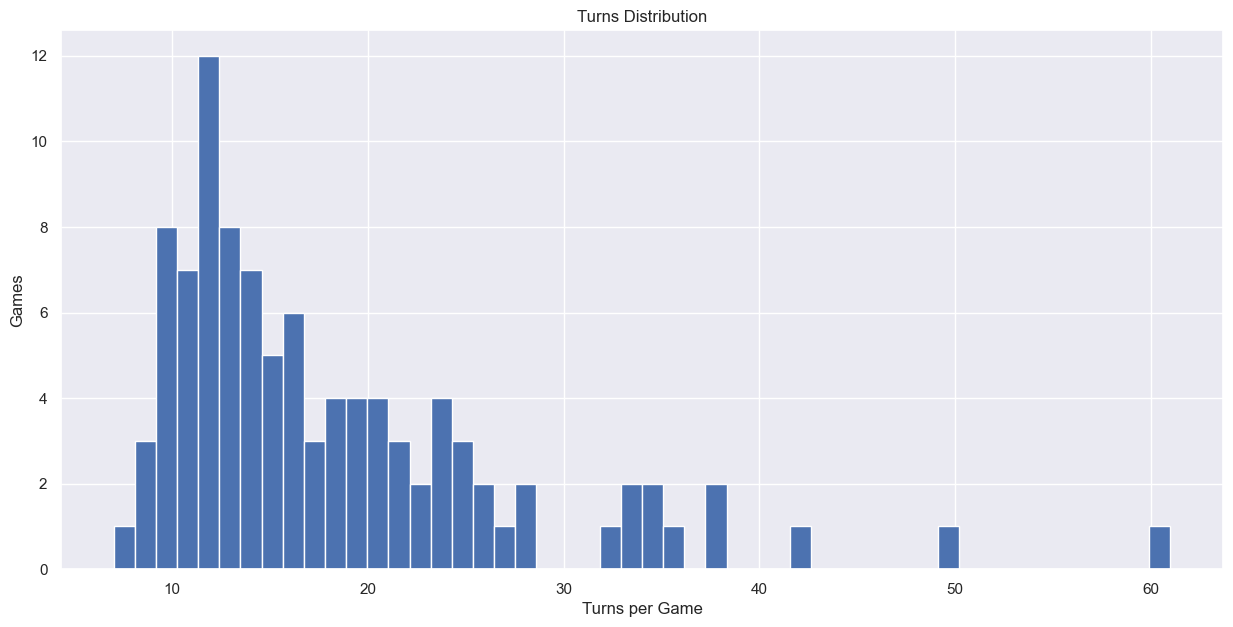

In [12]:
fig = plt.figure(1, figsize=(15, 7))

plt.hist(df["Turns"], bins=50, edgecolor = "w")
plt.title("Turns Distribution")
plt.xlabel("Turns per Game")
plt.ylabel("Games")

plt.show()

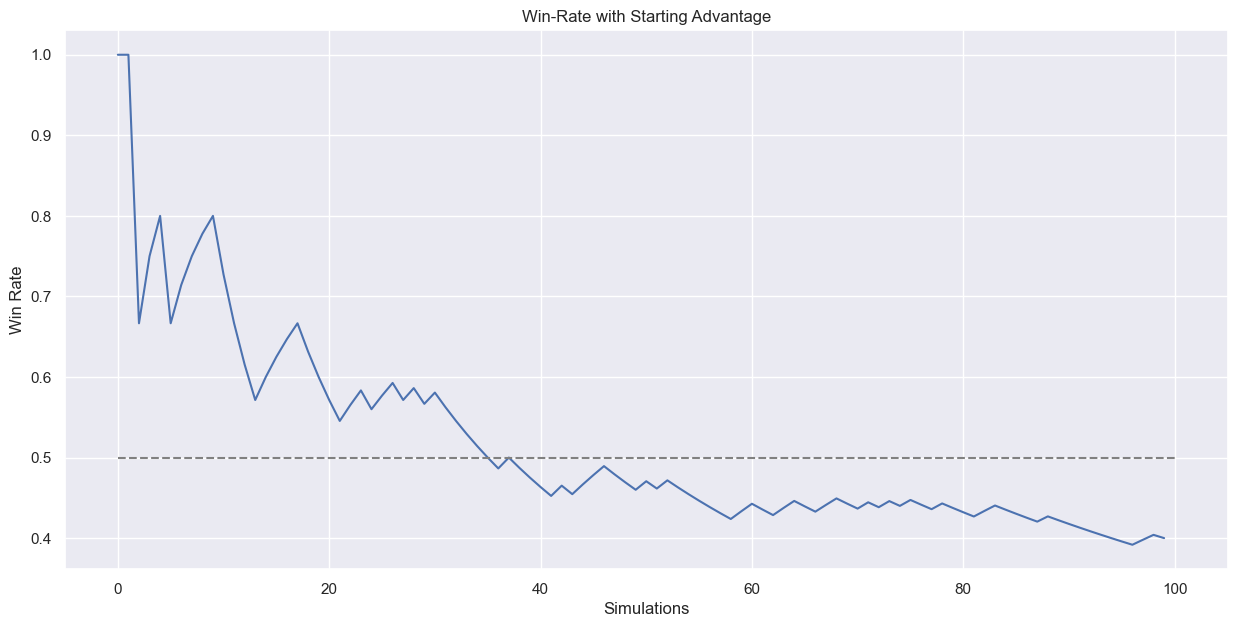

In [4]:
fig = plt.figure(1, figsize=(15, 7))

plt.plot(df.index, df["Rate"])
plt.hlines(0.5, 0, len(df), colors="grey", linestyles="dashed")

plt.title("Win-Rate with Starting Advantage")
plt.xlabel("Simulations")
plt.ylabel("Win Rate")
plt.show()

#### Q-Values

In [ ]:
q_values = pd.read_csv('../data/q.csv')

actions = q_values.columns

q_values['MAX'] = q_values.max(axis=1)
q_values['ID'] = q_values.index
q_values['HAND'] = q_values['ID'].apply(lambda x: sum(eval(x)[4:]))

q_values.drop(columns='ID', inplace=True)
q_values.head(3)

In [ ]:
q_curve = q_values.copy()
q_curve[["HAND","MAX"]] = q_curve[["HAND","MAX"]].replace(0, np.NaN)

q_mean = pd.Series(q_curve.groupby("HAND").mean()["MAX"])
q_max  = pd.Series(q_curve.groupby("HAND").max()["MAX"])
q_std  = pd.Series(q_curve.groupby("HAND").std()["MAX"])/2

fig = plt.figure(1, figsize=(15,7))
colors = color_lib(["Mean","Max"])

plt.plot(q_mean.index, q_mean, label="Mean", marker = "o", c = colors["Mean"])
plt.plot(q_max.index,  q_max,  label="Max",  marker = "o", c = colors["Max"])
plt.fill_between(q_mean.index, q_mean-q_std, q_mean+q_std, color = colors["Mean"], alpha=0.2)

plt.xticks(q_mean.index)
plt.xlabel("Number of Minimum Hand Cards")
plt.ylabel("Q-Value")
plt.title("Aggregated Q-Values")
plt.legend()
plt.show()

In [ ]:
q_pivot = q_values.replace(0, np.NaN)
q_pivot = q_pivot.drop(columns='MAX').groupby("HAND").mean()

# Plotting
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(q_pivot, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Q Values")
ax.set(xlabel="Action taken", ylabel="Hand Cards")
plt.show()